## OIL DATA ANALYTICS PROJECT

#### SETUP

In [85]:
# Download R libraries for analysis
library(xts)
library(dplyr)
library(ggplot2)
library(quantmod)
library(lubridate)

In [55]:
# Download R libraries for Visualization
# install.packages("highcharter")
# install.packages("forecast")
library(highcharter)
library(forecast)

In [3]:
# Connect to Quandl library
library(Quandl)
my_api <- "xq44Ss4a-fZGqgecyG1o"
Quandl.api_key(my_api)

#### Oil Futures Data Exploration

In [4]:
#  Get Historical Futures Prices: Crude Oil Futures from Quandl
CME_CL_Data <- Quandl('CHRIS/CME_CL1')

# Show the first 10 rows of the CME_CL_Data
head(CME_CL_Data, n=10)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-10-07,39.83,40.35,39.28,40.04,-0.72,39.95,427198,306975
2,2020-10-06,39.35,40.86,39.10,39.83,1.45,40.67,393993,324206
3,2020-10-05,37.00,39.72,37.00,39.35,2.17,39.22,371910,335875
4,2020-10-02,38.60,38.65,36.63,36.99,-1.67,37.05,384067,345967
5,2020-10-01,39.90,40.47,37.61,38.58,-1.50,38.72,435337,350342
6,2020-09-30,39.16,40.37,38.68,39.86,0.93,40.22,354437,355971
7,2020-09-29,40.58,40.70,38.41,39.11,-1.31,39.29,392396,355663
8,2020-09-28,40.07,40.80,39.78,40.57,0.35,40.60,221523,355229
9,2020-09-25,40.15,40.64,39.71,40.04,-0.06,40.25,224340,360410


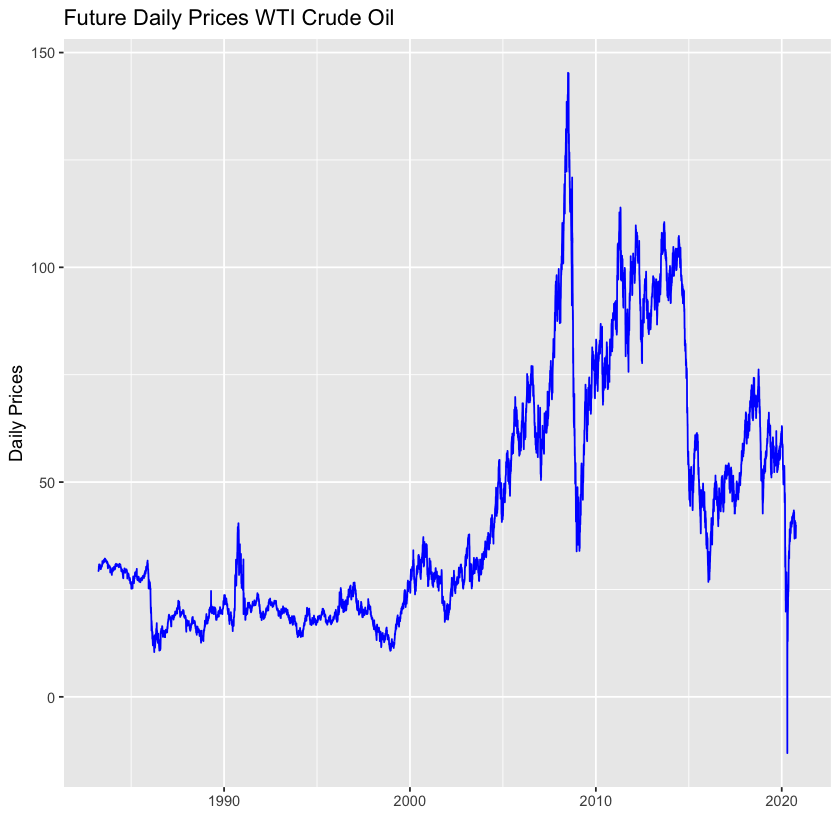

In [5]:
# Plot the last price field of the Crude Oil Futures Historical Prices
ggplot(CME_CL_Data, aes(Date, Last)) + geom_line(color = "blue") + xlab("") + ylab("Daily Prices")+   ggtitle("Future Daily Prices WTI Crude Oil") 

In [6]:
# Inverse the order of CME_CL_Data dataframe to have the oldest data at first and the latest data at the bottom. 
# We would use the arrange command from dplyr to achieve this. The data frame CME_CL_Data_ starts from 
# the oldest data of the CL future continuous series from Quandl
 
CME_CL_Data_ <- CME_CL_Data %>% arrange(rev(rownames(.)))
 
# It seems that dates are not consecutive. This issue was observed when we reverse 
# the series and is present most at the beginning of the series. So, sometimes
# we have nonconsecutive dates in subsequent rows. To avoid this, we will sort
# the CME_CL_DATA_ by consecutive dates. The command arrange from dplyr would # do this task.


CME_CL_Data_ <- CME_CL_Data_ %>%
  mutate(date = as.Date(Date, "%d-%m-%Y")) %>%
  arrange(date)
 
# Calculate the returns  
CME_CL_Data_$returns <- as.numeric(c('NA',diff(log(CME_CL_Data_$Last))))

# Remove outliers from the CME_CL_DATA_ , that are values with daily returns greater than 0.3

CME_CL_Data_ <- CME_CL_Data_[!abs(CME_CL_Data_$returns) > 0.3,]

# Select only numeric columns from the CME_CL_Data_ dataframe in order to summarize   the numeric columns. This can be done with the select_if command from dplyr package

CL_DATA <- select_if(CME_CL_Data_, is.numeric)

# Get the number of NAN values by column
na_cols_count <-sapply(CL_DATA, function(y) sum(length(which(is.na(y)))))
 
# The Change column has a lot of null values. So we would 
# separate this column from the others. Using the select command from dplyr 
# package we can do this task. The c() vector contain the columns position that we want to keep.

CL_DATA <- select(CL_DATA,c(1,2,3,4,6,7,8,9))

# Remove rows with Nan values using complete.cases command
CL_DATA <- CL_DATA[complete.cases(CL_DATA),]

# The statistic function will calculate some metrics such as mean, standard deviation, median, max and min for each of the columns. 

statistics <- do.call(data.frame, 
                      list(mean = round(apply(CL_DATA, 2, mean),4),
                           sd = round(apply(CL_DATA, 2, sd),4),
                           median = round(apply(CL_DATA, 2, median),4),
                           min = round(apply(CL_DATA, 2, min),4),
                         max = round(apply(CL_DATA, 2, max),4)))
statistics

Warning message in log(CME_CL_Data_$Last):
“NaNs produced”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,mean,sd,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Open,43.0802,28.1747,30.3500,10.000,145.190
High,43.6698,28.5300,30.6100,11.020,147.270
Low,42.4599,27.7709,30.1000,9.750,143.220
Last,43.0828,28.1674,30.3600,10.420,145.290
Settle,43.0817,28.1680,30.3600,10.420,145.290
Volume,166115.3112,202963.2134,69873.0000,0.000,1389653.000
Previous Day Open Interest,152590.1039,138868.0193,98083.0000,0.000,642793.000
returns,0.0001,0.0247,0.0004,-0.285,0.218


#### Exploring Oil Prices Data: WTI, BRENT, ARAB LIGHT

In [63]:
# WTI monthly data
WTI <- Quandl("FRED/DCOILWTICO", 
                    type = "xts", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-06-01")
index(WTI) <- seq(mdy('01/01/1990'), mdy(last(index(WTI))), by = 'months')
str(WTI)
head(WTI)

An ‘xts’ object on 1990-01-01/2020-06-01 containing:
  Data: num [1:366, 1] 22.7 21.6 20.3 18.5 17.5 ...
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


            [,1]
1990-01-01 22.69
1990-02-01 21.55
1990-03-01 20.34
1990-04-01 18.50
1990-05-01 17.47
1990-06-01 17.05

In [64]:
# BRENT monthly data
BRENT <- Quandl("FRED/DCOILBRENTEU", 
                    type = "xts", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-06-01")
index(BRENT) <- seq(mdy('01/01/1990'), mdy(last(index(BRENT))), by = 'months')
str(BRENT)
head(BRENT)

An ‘xts’ object on 1990-01-01/2020-06-01 containing:
  Data: num [1:366, 1] 20.5 19.2 17.9 16.4 15.3 ...
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


            [,1]
1990-01-01 20.50
1990-02-01 19.20
1990-03-01 17.95
1990-04-01 16.35
1990-05-01 15.30
1990-06-01 15.73

In [65]:
# ARAB LIGHT monthly data
ARAB_LIGHT <- Quandl("EIA/PET_ISA4990008_M", 
                    type = "xts", start_date = "1990-01-01", 
                    end_date = "2020-06-01")
#index(ARAB_LIGHT) <- seq(mdy('01/01/1990'), mdy(last(index(ARAB_LIGHT))), by = 'months')
str(ARAB_LIGHT)
head(ARAB_LIGHT)

An ‘xts’ object on Jan 1990/May 2020 containing:
  Data: num [1:358, 1] 19.7 18.7 16.8 14.9 14.7 ...
  Indexed by objects of class: [yearmon] TZ: UTC
  xts Attributes:  
 NULL


          [,1]
Jan 1990 19.73
Feb 1990 18.71
Mar 1990 16.76
Apr 1990 14.86
May 1990 14.72
Jun 1990 15.48

In [89]:
oil_data <- merge(WTI,BRENT, ARAB_LIGHT, all=TRUE)
hchart(oil_data)

HTML widgets cannot be represented in plain text (need html)

In [90]:
# WTI monthly data
wti_zoo <- Quandl("FRED/DCOILWTICO", 
                    type = "zoo", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-09-01")
# index(WTI) <- seq(mdy('01/01/1990'), mdy(last(index(WTI))), by = 'months')
str(wti_zoo)
wti_ts <- as.ts(wti_zoo)
# head(wti_ts)
is.ts(wti_ts)

‘zooreg’ series from Jan 1990 to Sep 2020
  Data: num [1:369] 22.7 21.6 20.3 18.5 17.5 ...
  Index:  'yearmon' num [1:369] Jan 1990 Feb 1990 Mar 1990 Apr 1990 ...
  Frequency: 12 


[1] TRUE

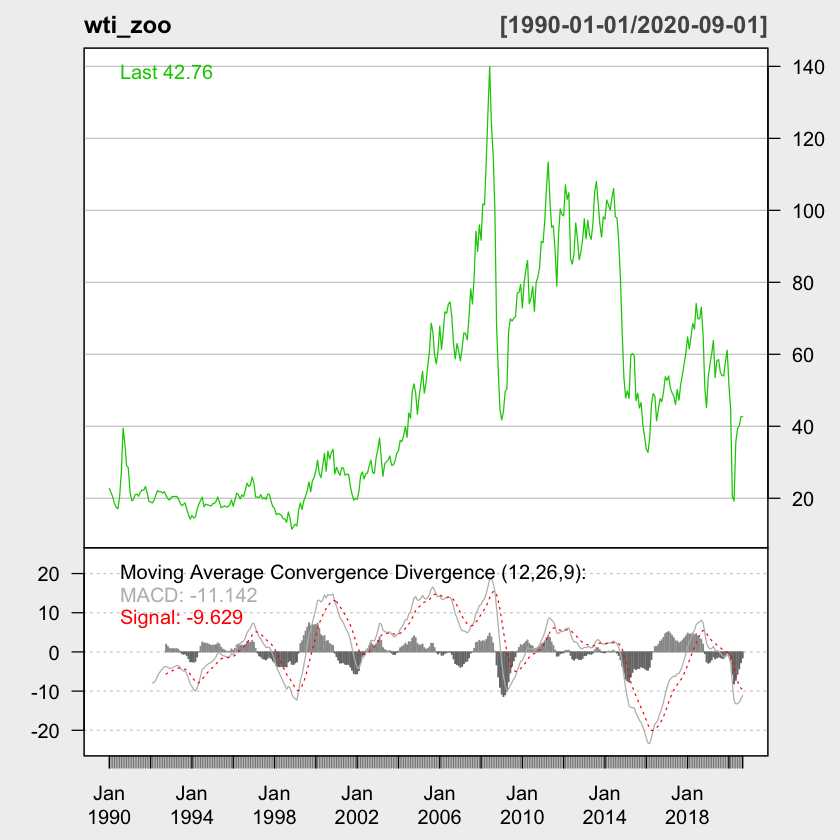

In [91]:
chartSeries(wti_zoo, theme="white", TA=c(addMACD(),addVo()))

In [92]:
oil_statistics <- do.call(data.frame, 
                      list(mean = round(apply(oil_data, 2, mean),4),
                           sd = round(apply(oil_data, 2, sd),4),
                           median = round(apply(oil_data, 2, median),4),
                           min = round(apply(oil_data, 2, min),4),
                         max = round(apply(oil_data, 2, max),4)))
oil_statistics

,mean,sd,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WTI,47.7773,29.2695,40.985,11.37,139.96
BRENT,49.0725,32.8100,40.090,9.91,138.40
ARAB_LIGHT,NA,NA,NA,NA,NA


In [93]:
str(oil_data)
head(oil_data)

An ‘xts’ object on 1990-01-01/2020-06-01 containing:
  Data: num [1:366, 1:3] 22.7 21.6 20.3 18.5 17.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "WTI" "BRENT" "ARAB_LIGHT"
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


             WTI BRENT ARAB_LIGHT
1990-01-01 22.69 20.50      19.73
1990-02-01 21.55 19.20      18.71
1990-03-01 20.34 17.95      16.76
1990-04-01 18.50 16.35      14.86
1990-05-01 17.47 15.30      14.72
1990-06-01 17.05 15.73      15.48

#### Time-Series Analysis in R

In [94]:
# Convert XTS to Time Series
str(oil_data)
oil_data_ts <- ts(oil_data, start = c(1990,1,1), frequency = 12)
head(oil_data_ts)
str(oil_data_ts)
is.ts(oil_data_ts)

An ‘xts’ object on 1990-01-01/2020-06-01 containing:
  Data: num [1:366, 1:3] 22.7 21.6 20.3 18.5 17.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "WTI" "BRENT" "ARAB_LIGHT"
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


,WTI,BRENT,ARAB_LIGHT
Jan 1990,22.69,20.50,19.73
Feb 1990,21.55,19.20,18.71
Mar 1990,20.34,17.95,16.76
Apr 1990,18.50,16.35,14.86
May 1990,17.47,15.30,14.72
Jun 1990,17.05,15.73,15.48


 Time-Series [1:366, 1:3] from 1990 to 2020: 22.7 21.6 20.3 18.5 17.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "WTI" "BRENT" "ARAB_LIGHT"
 - attr(*, "index")= num [1:366] 6.31e+08 6.34e+08 6.36e+08 6.39e+08 6.42e+08 ...
  ..- attr(*, "tzone")= chr "UTC"
  ..- attr(*, "tclass")= chr "Date"


[1] TRUE

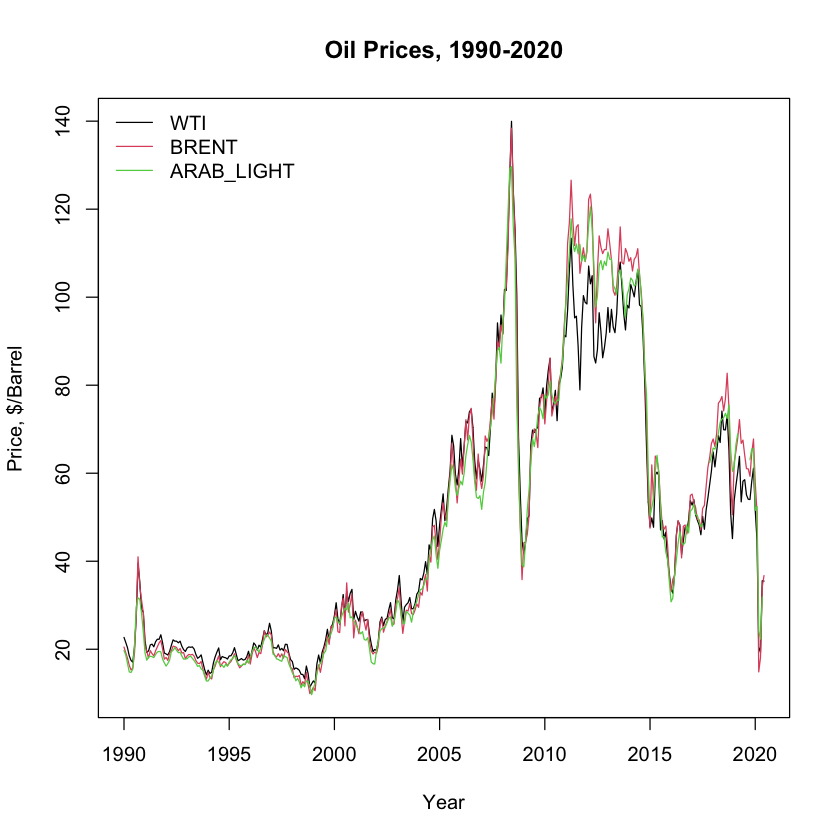

In [95]:
# Use ts.plot with eu_stocks
ts.plot(oil_data_ts, col = 1:3, xlab = "Year", ylab = "Price, $/Barrel", main = "Oil Prices, 1990-2020")

# Add a legend to your ts.plot
legend("topleft", colnames(oil_data_ts), lty = 1, col = 1:3, bty = "n")


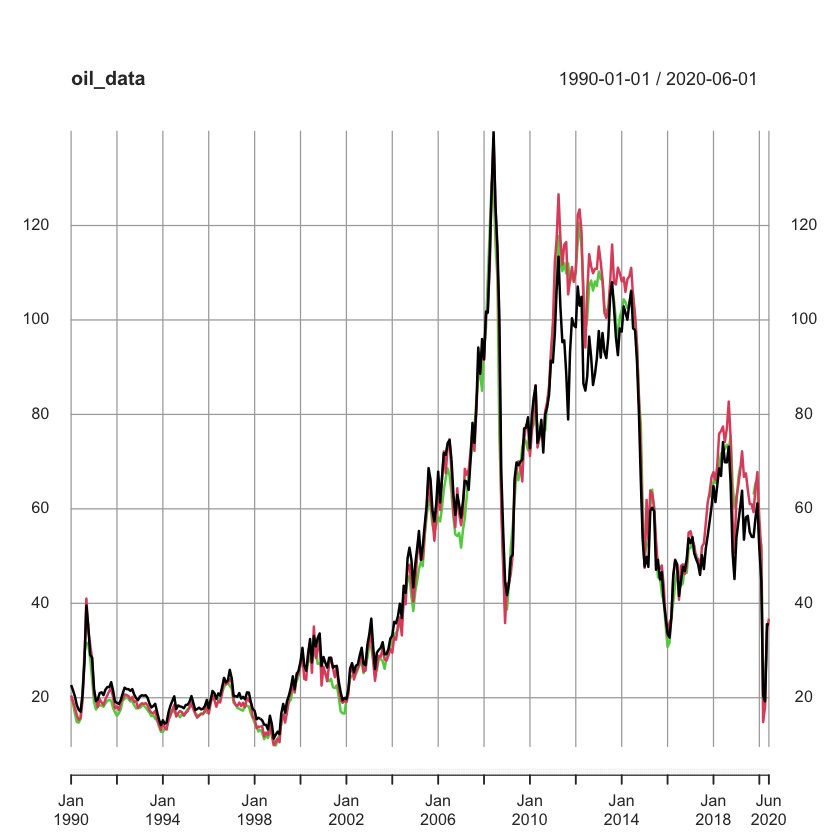

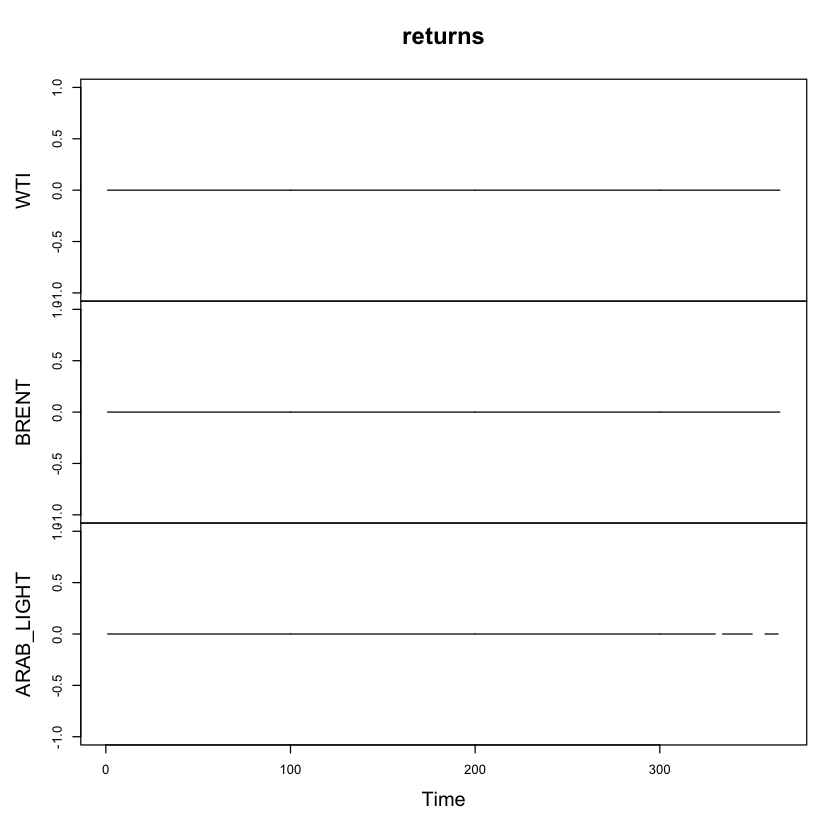

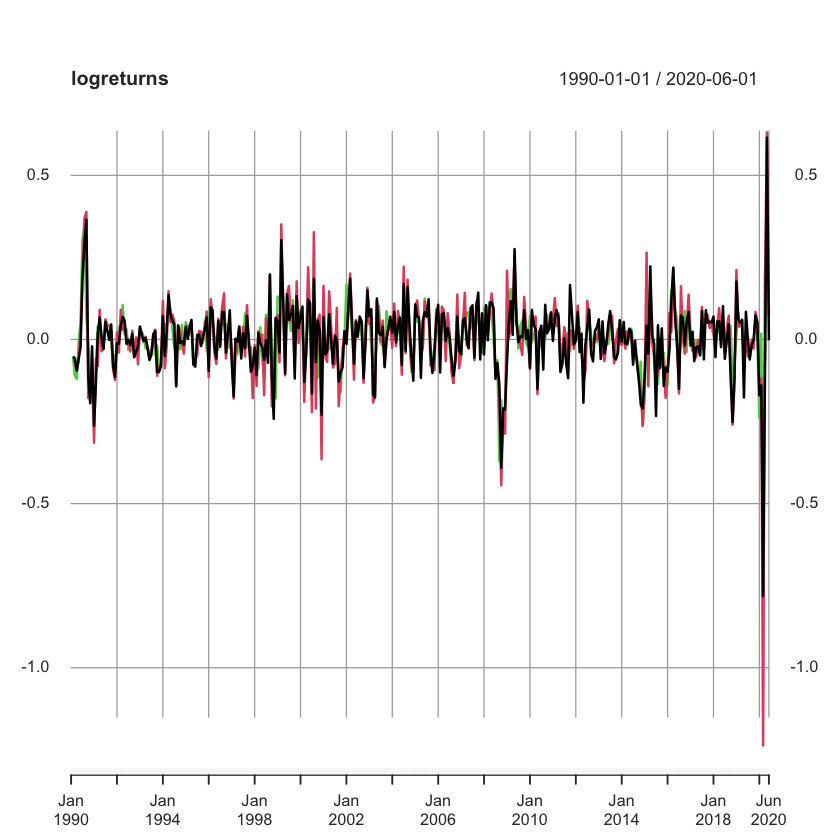

In [96]:
# Plot oil data
plot(oil_data)

# Use this code to convert prices to returns
returns <- oil_data[-1,] / oil_data[-369,]-1

# Convert returns to ts
returns <- ts(returns)

# Plot returns
plot(returns)

# Use this code to convert prices to log returns
logreturns <- diff(log(oil_data))

# Plot logreturns
plot(logreturns)


In [97]:
# Create Time Series Objects per each Oil Type
wti_ts <- as.ts(oil_data$WTI)
brent_ts <- as.ts(oil_data$BRENT)
arab_light_ts <- as.ts(oil_data$ARAB_LIGHT)

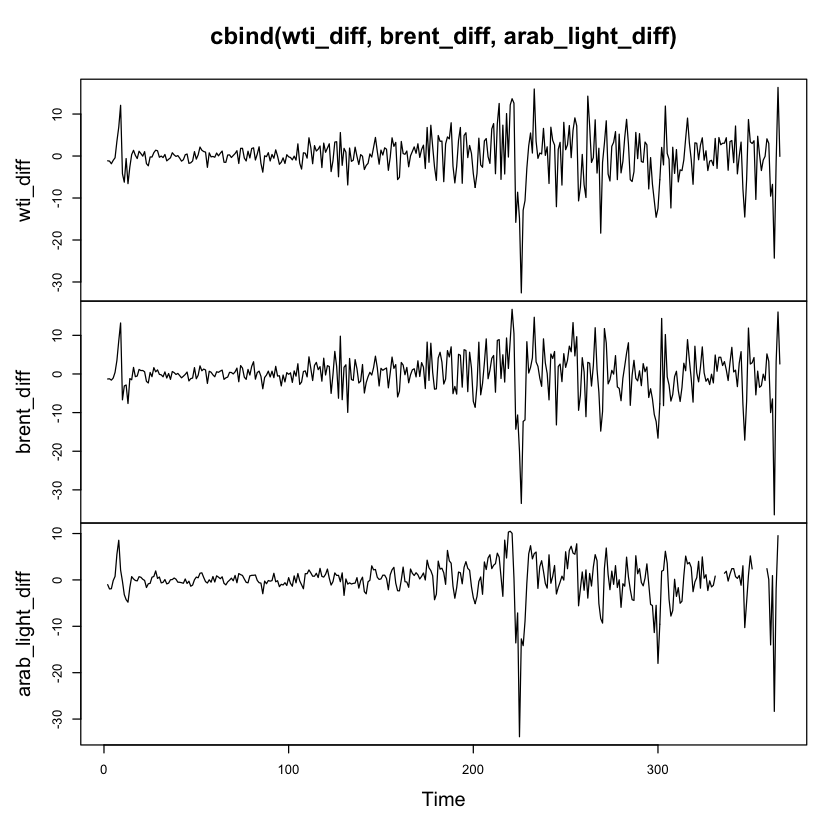

In [98]:
# Generate the first difference of oil_data_ts
wti_diff <- diff(wti_ts)
brent_diff <- diff(brent_ts)
arab_light_diff <- diff(arab_light_ts)
  
# Plot dz
plot.ts(cbind(wti_diff,brent_diff, arab_light_diff))
# par(mfrow=c(1,3))
# ts.plot(wti_diff)
# ts.plot(brent_diff)
# ts.plot(arab_light_diff)

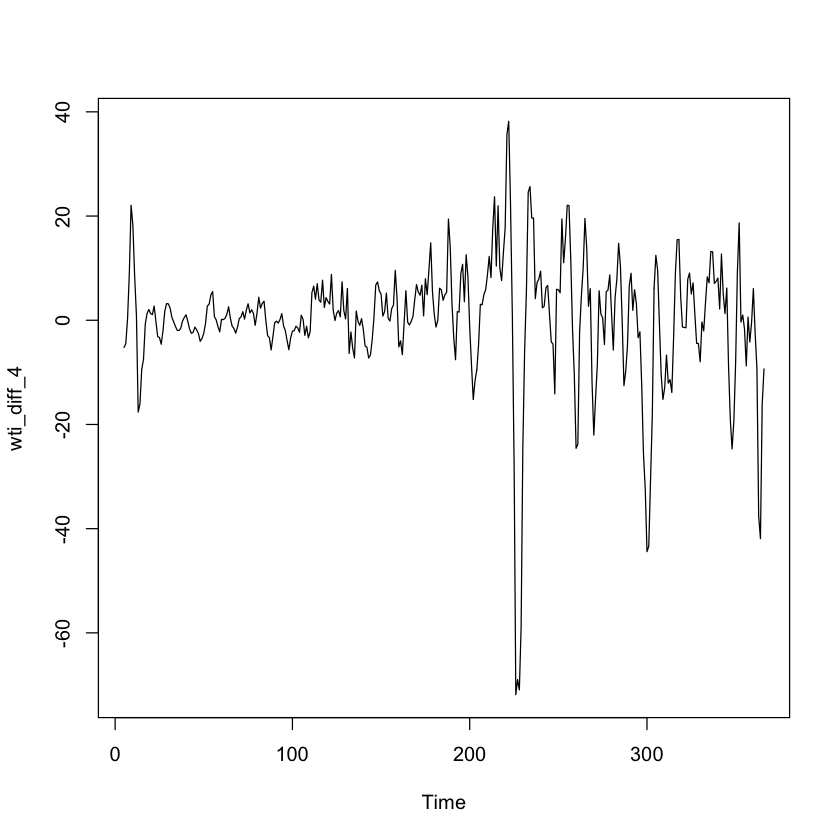

In [99]:
# Generate a diff of x with lag = 4. Save this to dx
wti_diff_4 <- diff(wti_ts, lag = 4)

# Plot dz
par(mfrow=c(1,1))
ts.plot(wti_diff_4)


#### Stationary process (White Noise Model)

In [100]:
# Fit the WN model to oil data using the arima command
arima(wti_ts, order = c(0, 0, 0))

# Calculate the sample mean and sample variance of y
mean(wti_ts)
var(wti_ts)


Call:
arima(x = wti_ts, order = c(0, 0, 0))

Coefficients:
      intercept
        47.7773
s.e.     1.5279

sigma^2 estimated as 854.4:  log likelihood = -1754.65,  aic = 3513.29

[1] 47.77732

[1] 856.7065

* From the comparisons we can see that the arima() function estimates are very close to the sample mean and variance estimates, in fact identical for the mean.

#### Non Stationary process (Random Walk Model)

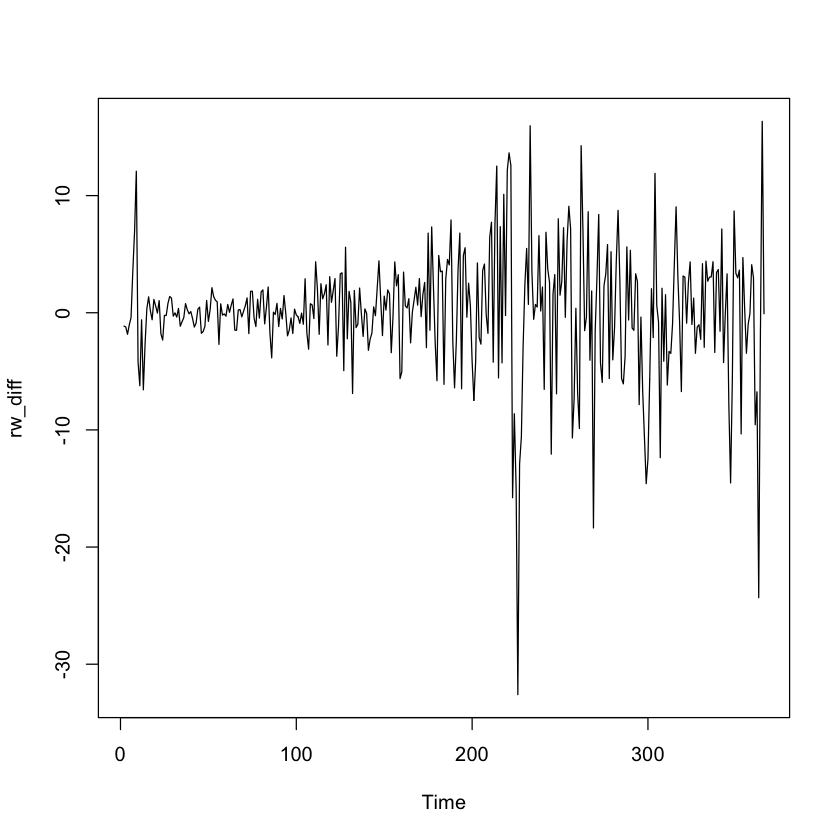

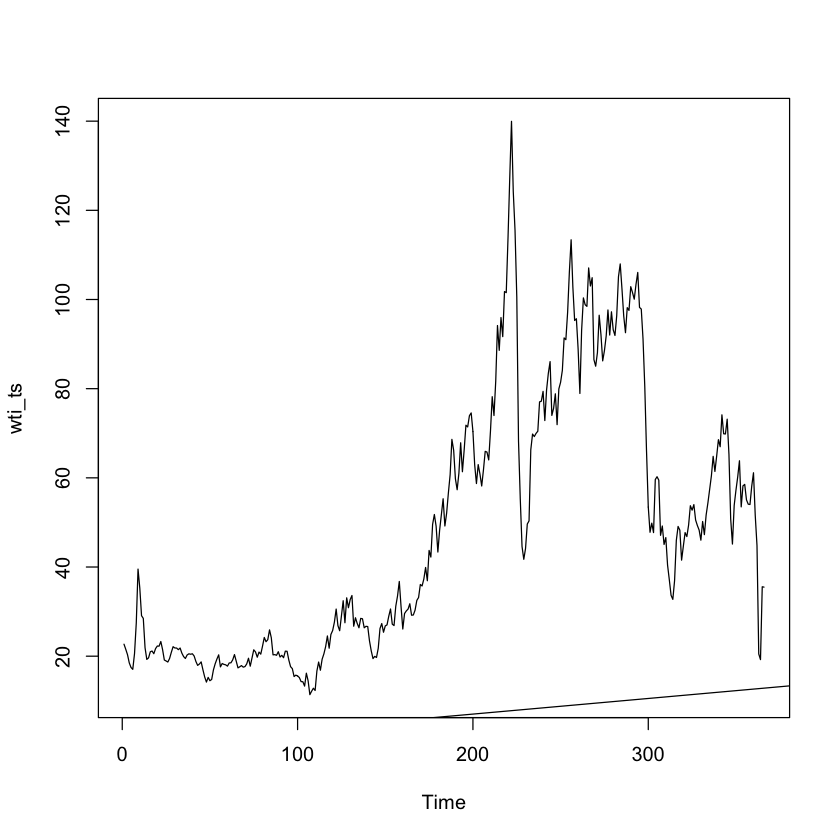

In [101]:
# Difference your random_walk data
rw_diff <- diff(wti_ts) 

# Plot rw_diff
ts.plot(rw_diff)

# Now fit the WN model to the differenced data
model_wn <- arima(rw_diff, order = c(0, 0, 0))

# Store the value of the estimated time trend (intercept)
int_wn <- model_wn$coef

# Plot the original random_walk data
ts.plot(wti_ts)

# Use abline(0, ...) to add time trend to the figure
abline(0,int_wn)

* The arima() command correctly identified the time trend in our original oil data.

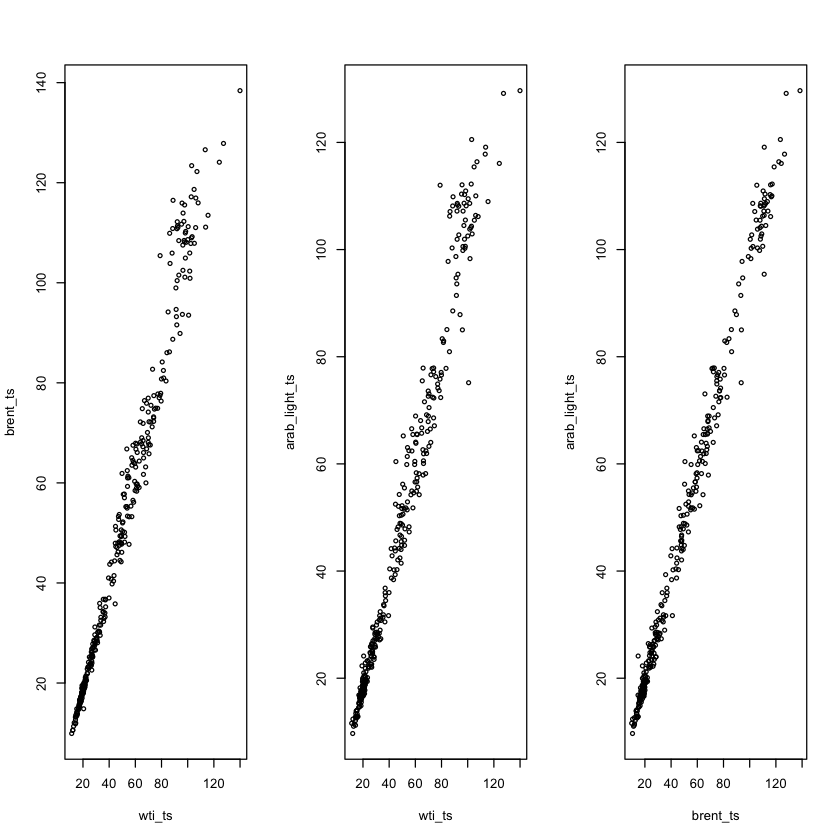

In [102]:
par(mfrow=c(1,3))
plot(wti_ts, brent_ts)
plot(wti_ts, arab_light_ts)
plot(brent_ts, arab_light_ts)

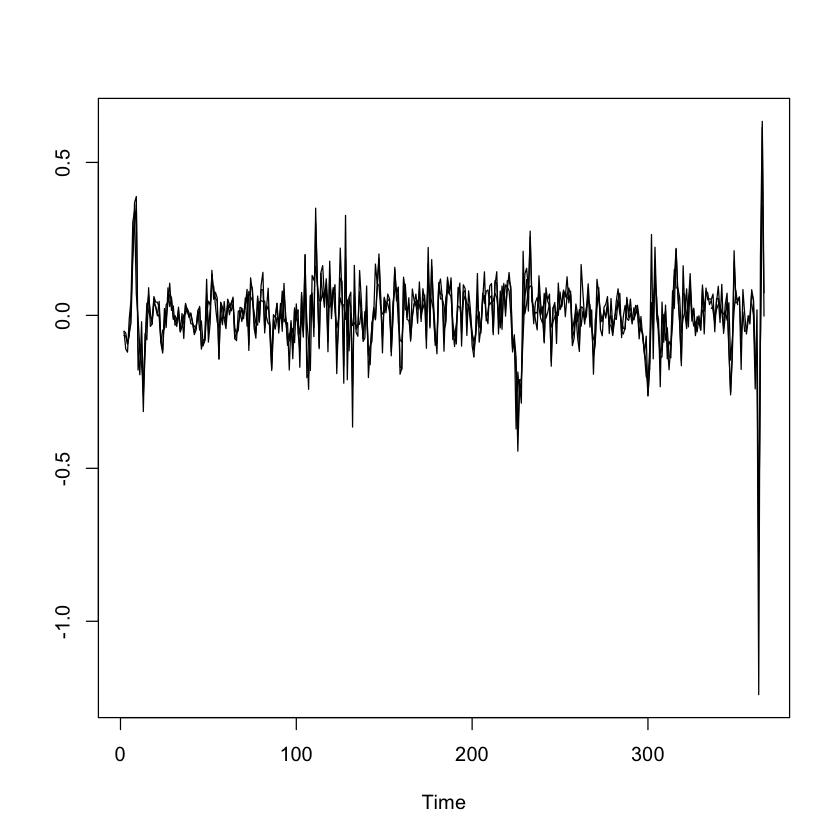

In [103]:
wti_log_return <- diff(log(wti_ts))
brent_log_return <- diff(log(brent_ts))
arab_light_log_return <- diff(log(arab_light_ts))
ts.plot(cbind(wti_log_return, brent_log_return, arab_light_log_return))

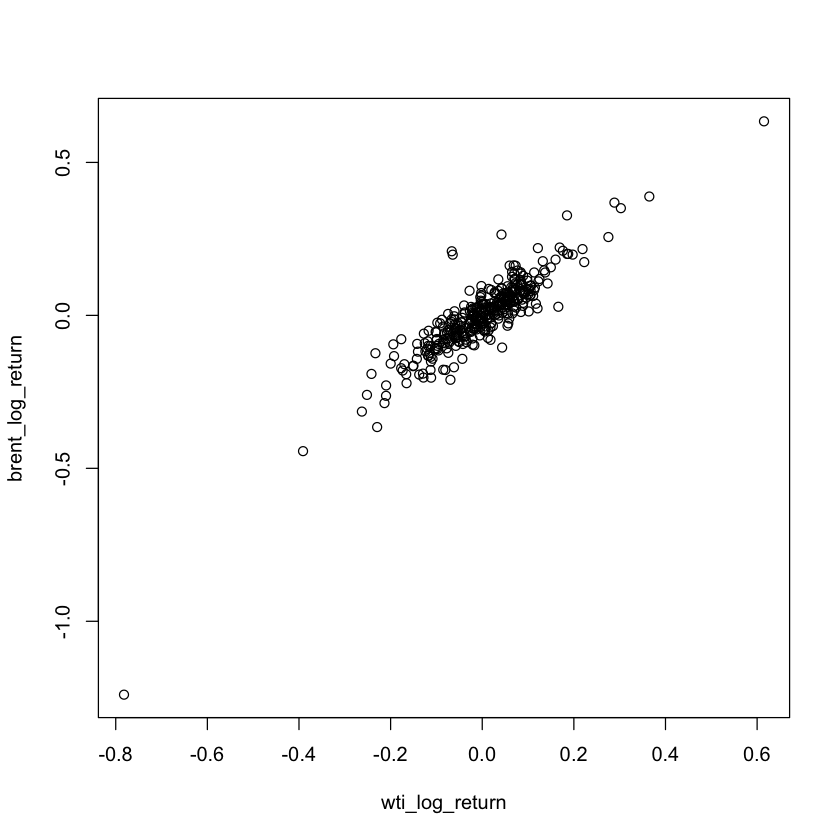

In [104]:
plot(wti_log_return, brent_log_return)

In [107]:
# Fit an arima model to our time series using the auto.arima() function from the forecast package
auto.arima(oil_data$WTI)

Series: oil_data$WTI 
ARIMA(2,1,2) 

Coefficients:
         ar1      ar2      ma1     ma2
      1.4608  -0.5760  -1.2660  0.3481
s.e.  0.1432   0.1504   0.1623  0.1706

sigma^2 estimated as 25.83:  log likelihood=-1109.46
AIC=2228.91   AICc=2229.08   BIC=2248.41

In [152]:
# WTI last monthly data
wti_data <- Quandl("FRED/DCOILWTICO", 
                    type = "xts", 
                    collapse = "monthly",  
                    start_date = "1990-01-01", 
                    end_date = "2020-10-01")
wti_2020 <- wti_data['2020',]
wti_2020[6:10]

          [,1]
Jun 2020 39.27
Jul 2020 40.10
Aug 2020 42.61
Sep 2020 40.05
Oct 2020 38.51

In [155]:
# Predict what WTI oil prices will look like over the next six months, based on the arima model we just fit
# Forecasting period June-December 2020
wti_forecast = auto.arima(oil_data$WTI) %>% forecast(h = 5)
wti_forecast

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
367       38.14928 31.63542 44.66315 28.18719 48.11138
368       40.29697 30.14768 50.44625 24.77498 55.81896
369       41.90258 28.88434 54.92082 21.99290 61.81227
370       43.01101 27.75129 58.27073 19.67328 66.34874
371       43.70537 26.71575 60.69500 17.72198 69.68876